In [1]:
from tensorflow import keras
import tensorflow as tf
# example of using a pre-trained model as a classifier
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Dense,
    Flatten
)
from tensorflow.keras import optimizers
from tensorflow.compat.v1 import InteractiveSession

config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth = True
#session = InteractiveSession(config=config)
config.gpu_options.per_process_gpu_memory_fraction = 0.7
tf.compat.v1.keras.backend.set_session(
    tf.compat.v1.Session(config=config))

from tensorflow.keras import optimizers

In [2]:
print("keras      {}".format(keras.__version__))
print("tensorflow {}".format(tf.__version__))

keras      2.4.0
tensorflow 2.4.1


In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn import preprocessing
import glob
import cv2
import numpy as np

import gc
from time import time
import logging

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

# Model

In [68]:
# load model without classifier layers
model = VGG16(weights='imagenet',include_top=False, input_tensor=Input(shape=(500, 500, 3)))



In [ ]:
## put aside

model = tf.keras.Sequential()
#model.add(tf.keras.layers.Dense(8, input_shape=(16,)))
model.add(tf.keras.applications.VGG16(
    include_top=False, weights='imagenet', input_tensor=None, input_shape=(500, 500, 3), pooling=None, classes=4,classifier_activation='softmax'))
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

In [69]:
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
class2 = Dense(512, activation='relu')(class1)
#class3 = Dense(256, activation='relu')(class2)
output = Dense(4, activation='softmax')(class2)
# define new model
model = Model(inputs=model.inputs, outputs=output)

In [70]:
# summarize
model.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 500, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 500, 500, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 250, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 250, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 250, 250, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 125, 125, 128)     0  

In [71]:
for layers in (model.layers)[1:19]:
    print(layers)
    layers.trainable = False

In [72]:
model.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 500, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 500, 500, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 250, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 250, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 250, 250, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 125, 125, 128)     0  

In [22]:
model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

# Data

In [9]:
X = np.load('data_v1.npy')
y = np.load('label_v1.npy')

### Broadcast X into 3 channels to fit with the input setup

In [10]:
X = np.repeat(X.reshape(-1, 500, 500, 1), 3, axis=3)
print('X_train.shape:', X.shape)

X_train.shape: (10646, 500, 500, 3)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=1234) # 0.25 x 0.8 = 0.2

In [12]:
print('Training data')
print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_train.type:', type(X_train))
print('y_train type:', type(y_train))
print('\n')
print('Validation data')
print('X_val.shape:', X_val.shape)
print('y_val.shape:', y_val.shape)
print('\n')
print('Testing data')
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)

del X, y
gc.collect()


Training data
X_train.shape: (8527, 500, 500, 3)
y_train.shape: (8527, 4)
X_train.type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>


Validation data
X_val.shape: (1054, 500, 500, 3)
y_val.shape: (1054, 4)


Testing data
X_test.shape: (1065, 500, 500, 3)
y_test.shape: (1065, 4)


220

# Training The Model

In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=40, verbose=1, mode='auto')
#model.fit_generator(generator= traindata, steps_per_epoch= 2, epochs= 100, validation_data= testdata, validation_steps=1, callbacks=[checkpoint,early])


Using TensorFlow backend.


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.0,  # Randomly zoom image
    width_shift_range=0.0,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.0,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images horizontally
    vertical_flip=False, # Don't randomly flip images vertically
)  

In [15]:
batch_size = 4
img_iter = datagen.flow(X_train, y_train, batch_size=batch_size)

In [ ]:
model.fit(img_iter,
          epochs=5,
          steps_per_epoch=len(X_train)/batch_size, # Run same number of steps we would if we were not using a generator.
          validation_data=(X_val, y_val))

In [19]:
model.save_weights("vgg16_2.h5")
model.save('pretrainedVGG16_seq_model_v2')

INFO:tensorflow:Assets written to: pretrainedVGG16_seq_model_v1/assets


# Re Training with unfrozen layers

In [20]:
for layers in (model.layers)[1:19]:
    print(layers)
    layers.trainable = True

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 500, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 500, 500, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 250, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 250, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 250, 250, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 125, 125, 128)     0     

In [22]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),  # Very low learning rate
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()])

In [17]:
model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.00001,momentum=0.9), metrics=["accuracy"])

In [18]:
model.fit(img_iter,
          epochs=3,
          steps_per_epoch=100, # Run same number of steps we would if we were not using a generator.
          validation_data=(X_val, y_val))

Epoch 1/3
100/100 [==============================] - 34s 311ms/step - loss: 0.1594 - accuracy: 0.9532 - val_loss: 0.2326 - val_accuracy: 0.9298
Epoch 2/3
100/100 [==============================] - 21s 210ms/step - loss: 0.2977 - accuracy: 0.8932 - val_loss: 0.2705 - val_accuracy: 0.9279
Epoch 3/3
100/100 [==============================] - 21s 210ms/step - loss: 0.2216 - accuracy: 0.9351 - val_loss: 0.2706 - val_accuracy: 0.9108


In [35]:
model.save('newtrainedVGG16_seq_model_v2')

INFO:tensorflow:Assets written to: newtrainedVGG16_seq_model_v1/assets


In [4]:
model = keras.models.load_model('newtrainedVGG16_seq_model_v1')

In [4]:
model.evaluate(X_test, y_test)

NameError: name 'X_test' is not defined

In [11]:
y_pred = model.predict(X_test)

In [12]:
y_pred

array([[9.9611723e-01, 6.9792790e-04, 2.9423034e-03, 2.4263507e-04],
       [1.9954245e-05, 3.3965971e-02, 8.3182540e-06, 9.6600580e-01],
       [5.6289174e-03, 8.5375661e-01, 1.2361879e-03, 1.3937826e-01],
       ...,
       [2.3618367e-07, 3.9372135e-06, 9.9997473e-01, 2.1040618e-05],
       [6.4179301e-01, 3.5034308e-01, 8.6422538e-04, 6.9997152e-03],
       [2.2887015e-03, 9.9575788e-01, 1.1409207e-05, 1.9420002e-03]],
      dtype=float32)

### GRAD-CAM

##### https://fairyonice.github.io/Grad-CAM-with-keras-vis.html

##### also see... https://fairyonice.github.io/Saliency-Map-with-keras-vis.html

In [3]:
import vis ## keras-vis

In [5]:
model = keras.models.load_model('newtrainedVGG16_seq_model_v1')

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 500, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 500, 500, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 250, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 250, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 250, 250, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 125, 125, 128)     0     

In [7]:
model.summary()
for ilayer, layer in enumerate(model.layers):
    print("{:3.0f} {:10}".format(ilayer, layer.name))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 500, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 500, 500, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 250, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 250, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 250, 250, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 125, 125, 128)     0     

In [8]:
model.layers

#### HOLD OFF ON THESE BLOCKS

In [ ]:
!wget "https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json"

In [ ]:
import json
CLASS_INDEX = json.load(open("imagenet_class_index.json"))
classlabel  = []
for i_dict in range(len(CLASS_INDEX)):
    classlabel.append(CLASS_INDEX[str(i_dict)][1])
print("N of class={}".format(len(classlabel)))

#### RESUME FROM HERE

In [5]:
classlabel = ['AFIB', 'GSVT', 'SB', 'SR']
classlabel

['AFIB', 'GSVT', 'SB', 'SR']

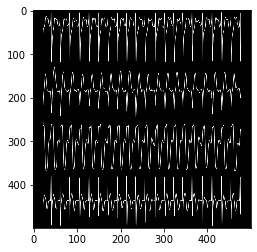

In [10]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#_img = load_img("duck.jpg",target_size=(224,224))
_img = load_img("XAI_test.jpg",target_size=(500,500,3))
plt.imshow(_img)
plt.show()

In [16]:
img               = img_to_array(_img)
#img               = preprocess_input(img)
y_pred            = model.predict(img[np.newaxis,...])
class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]
topNclass         = 4
for i, idx in enumerate(class_idxs_sorted[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
          i + 1,classlabel[idx],idx,y_pred[0,idx]))

Top 1 predicted class:     Pr(Class=GSVT               [index=1])=0.875
Top 2 predicted class:     Pr(Class=AFIB               [index=0])=0.125
Top 3 predicted class:     Pr(Class=SR                 [index=3])=0.000
Top 4 predicted class:     Pr(Class=SB                 [index=2])=0.000


In [26]:
classlabel

['AFIB', 'GSVT', 'SB', 'SR']

In [18]:
from vis.utils import utils
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model,'dense_1')
# Swap softmax with linear
model.layers[layer_idx].activation = keras.activations.linear
model = utils.apply_modifications(model)

ValueError: Unknown layer: Functional

In [ ]:
from vis.visualization import visualize_cam
penultimate_layer_idx = utils.find_layer_idx(model, "block5_conv3") 
class_idx  = class_idxs_sorted[0]
seed_input = img
grad_top1  = visualize_cam(model, layer_idx, class_idx, seed_input, 
                           penultimate_layer_idx = penultimate_layer_idx,#None,
                           backprop_modifier     = None,
                           grad_modifier         = None)

In [ ]:
def plot_map(grads):
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(_img)
    axes[1].imshow(_img)
    i = axes[1].imshow(grads,cmap="jet",alpha=0.8)
    fig.colorbar(i)
    plt.suptitle("Pr(class={}) = {:5.2f}".format(
                      classlabel[class_idx],
                      y_pred[0,class_idx]))
plot_map(grad_top1)

In [ ]:
for class_idx in class_idxs_sorted[:topNclass]:
    grads  = visualize_cam(model,layer_idx,class_idx, seed_input,
                           penultimate_layer_idx = penultimate_layer_idx,
                           backprop_modifier     = None,
                           grad_modifier         = None)
    plot_map(grads)

### tf-Keras-vis

#### https://github.com/keisen/tf-keras-vis/blob/master/examples/attentions.ipynb

In [6]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

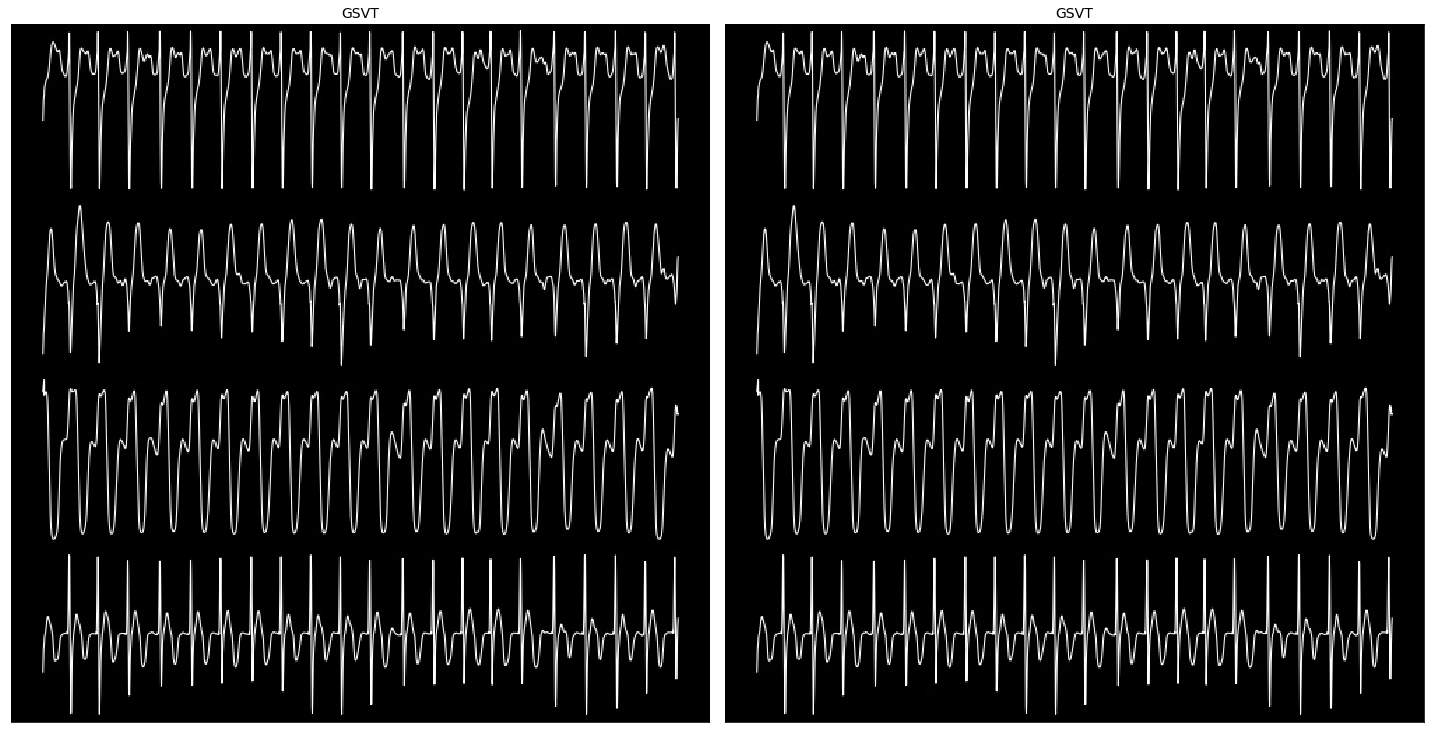

In [7]:
from tensorflow.keras.preprocessing.image import load_img

# Image titles
image_titles = ['GSVT', 'GSVT']

# Load images
img1 = load_img('XAI_test.jpg',target_size=(500,500,3))
img2 = load_img('XAI_test.jpg',target_size=(500,500,3))
#img3 = load_img('images/soldiers.jpg', target_size=(224, 224))
#images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])
images = np.asarray([np.array(img1), np.array(img2)])

# Preparing input data
X = preprocess_input(images)
Y = images
Y = tf.dtypes.cast(Y, tf.float32)

# Rendering
subplot_args = { 'nrows': 1, 'ncols': 2, 'figsize': (20, 10),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
plt.tight_layout()
plt.show()

In [8]:
# The `output` variable refer to the output of the model,
# so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
def loss(output):
    # 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
    return (output[0],output[1])

In [9]:
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

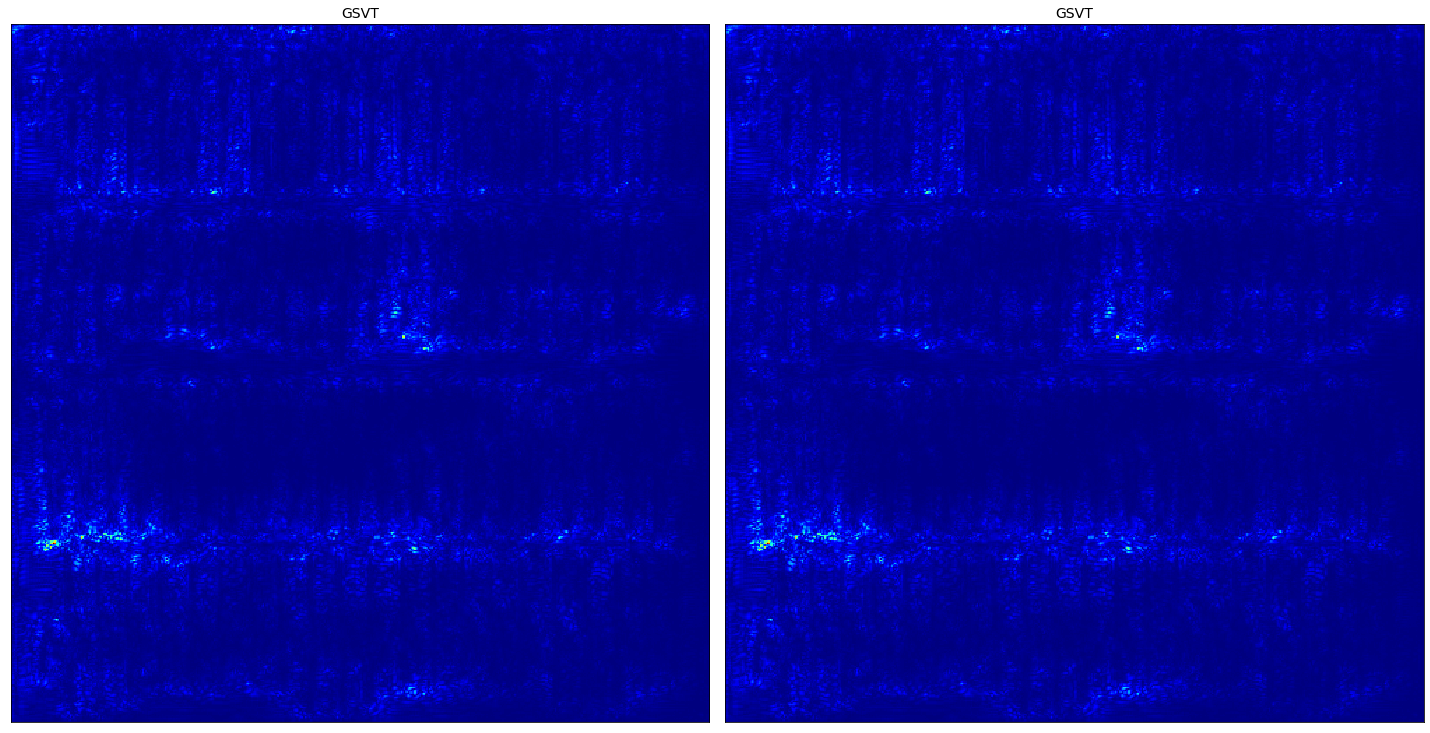

In [12]:
#VANILLA SALIENCY

#%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

# Create Saliency object.
# If `clone` is True(default), the `model` will be cloned,
# so the `model` instance will be NOT modified, but it takes a machine resources.
saliency = Saliency(model,
                    model_modifier=model_modifier,
                    clone=False)

# Generate saliency map
saliency_map = saliency(loss, X)
saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
plt.tight_layout()

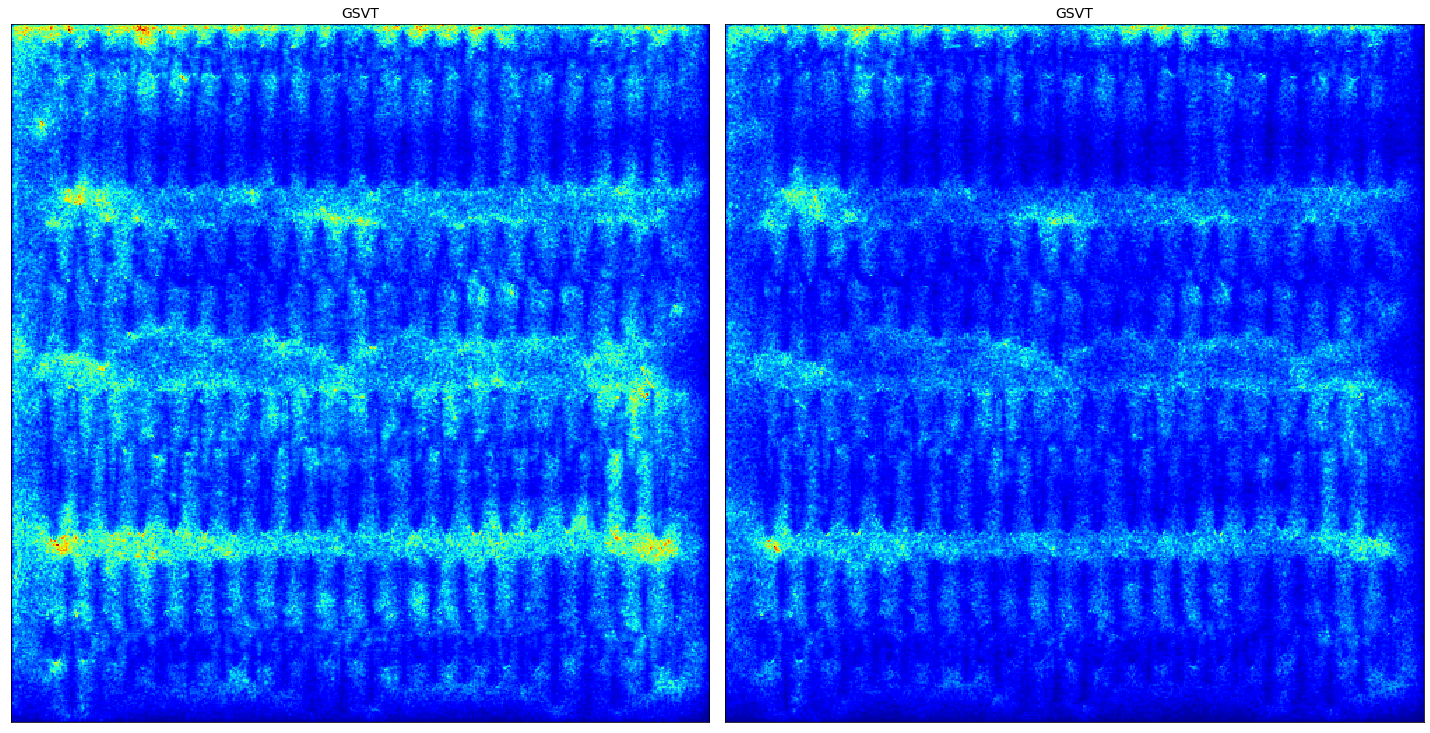

In [88]:
## SMOOTH GRAD

#%%time

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=model_modifier,
                    clone=False)

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(loss,
                        X,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.
saliency_map = normalize(saliency_map)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
plt.tight_layout()
plt.savefig('smoothgrad.png')
plt.show()

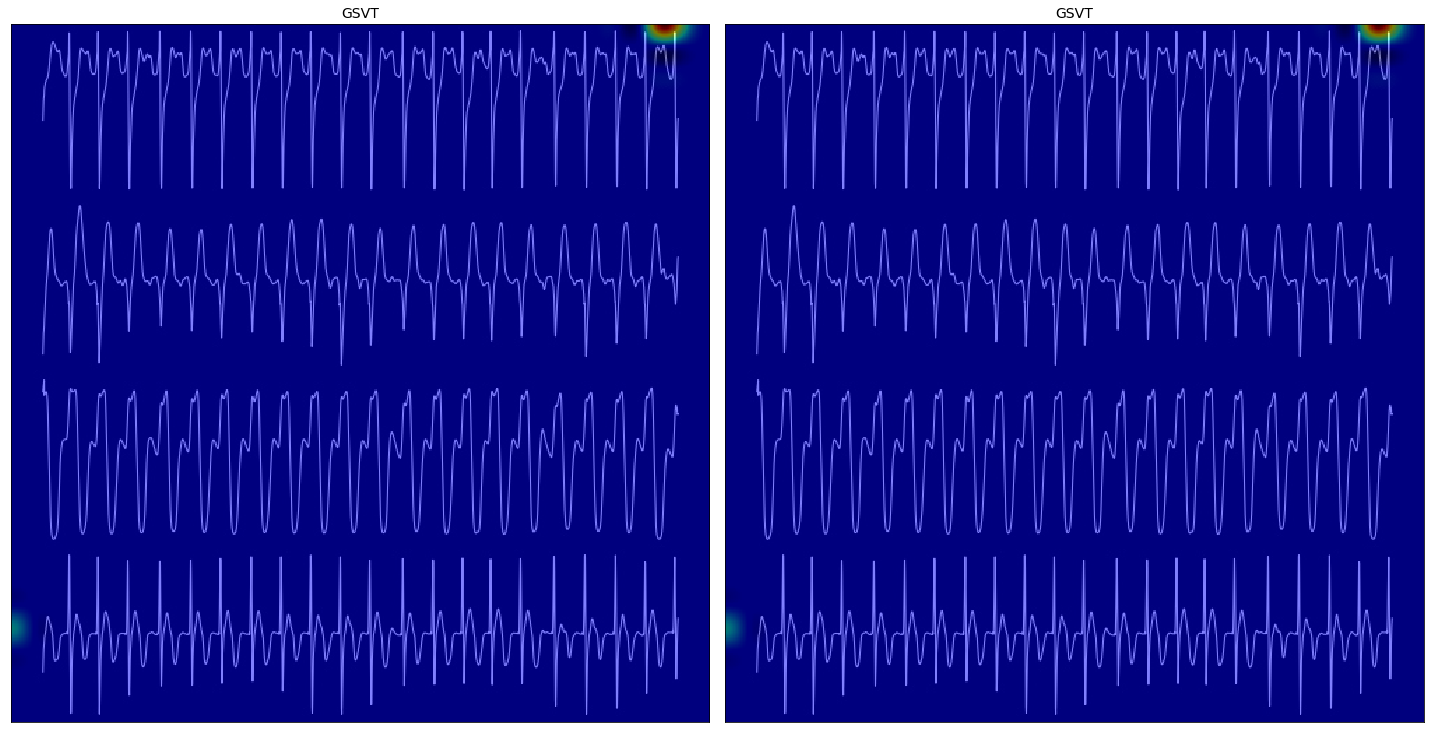

In [17]:
# GRAD CAM

#%%time

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=model_modifier,
                  clone=False)

# Generate heatmap with GradCAM
cam = gradcam(loss,
              X,
              penultimate_layer=18, # model.layers number
             )
cam = normalize(cam)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
plt.tight_layout()
plt.show()

In [98]:
# Grad CAM++

from tf_keras_vis.gradcam import GradcamPlusPlus

# Create GradCAM++ object, Just only repalce class name to "GradcamPlusPlus"
# gradcam = Gradcam(model, model_modifier, clone=False)
gradcam = GradcamPlusPlus(model,
                          model_modifier,
                          clone=False)

# Generate heatmap with GradCAM++
cam = gradcam(loss,
              X, #instead of X try raw
              penultimate_layer=-1, # model.layers number
             )
cam = normalize(cam)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
plt.tight_layout()
plt.savefig('gradcam_plus_plus.png')
plt.show()

InvalidArgumentError: Incompatible shapes: [8,1,1,1] vs. [2,31,31,512] [Op:Mul]

In [61]:
# SCORE CAM
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('{} GPUs'.format(gpus))
from tf_keras_vis.scorecam import ScoreCAM

# Create ScoreCAM object
scorecam = ScoreCAM(model, model_modifier, clone=False)

# This cell takes toooooooo much time, so only doing with GPU.
if gpus > 0:
    # Generate heatmap with ScoreCAM
    cam = scorecam(loss,
                   X,
                   penultimate_layer=-1, # model.layers number
                  )
    cam = normalize(cam)

    f, ax = plt.subplots(**subplot_args)
    for i, title in enumerate(image_titles):
        heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
        ax[i].set_title(title, fontsize=14)
        ax[i].imshow(images[i])
        ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("Let's run a next cell to show Faster-ScoreCAM")

1 GPUs


KeyboardInterrupt: 

In [87]:
#Faster Scorecam

from tf_keras_vis.scorecam import ScoreCAM

# Create ScoreCAM object
scorecam = ScoreCAM(model, model_modifier, clone=False)

# Generate heatmap with Faster-ScoreCAM
cam = scorecam(loss,
               Y,
               penultimate_layer=20, # model.layers number
               max_N=10
              )
cam = normalize(cam)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
plt.tight_layout()
plt.show()

ValueError: Cannot do batch_dot on inputs with different batch sizes. Received inputs with shapes (2, 31, 31, 10) and (8, 10).